In [11]:
#!pip install -U aeon
#!pip install aeon[all_extras]
import warnings
import pandas as pd
import numpy as np
from aeon.datasets import load_airline
from aeon.forecasting.arima import ARIMA
from matplotlib import pyplot as plt
from aeon.forecasting.arima import AutoARIMA
from aeon.forecasting.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
from aeon.visualisation import plot_series
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
warnings.filterwarnings("ignore")
%matplotlib inline

Metrics

In [12]:
def rmse(y_true, y_pred):
  return np.sqrt(mse(y_true, y_pred))

def pocid(y_true, y_pred):
    n = len(y_true)
    D = [1 if (y_pred[i] - y_pred[i-1]) * (y_true[i] - y_true[i-1]) > 0 else 0 for i in range(1, n)]
    POCID = 100 * np.sum(D) / n
    return POCID

def mcpm(rmse_result, mape_result, pocid_result):
  er_result = 100 - pocid_result

  A1 = (rmse_result * mape_result * np.sin((2*np.pi)/3))/2
  A2 = (mape_result * er_result * np.sin((2*np.pi)/3))/2
  A3 = (er_result * rmse_result * np.sin((2*np.pi)/3))/2
  total = A1 + A2 + A3
  return total

Normalization

In [13]:
def znorm(x):
  x_znorm = (x - np.mean(x)) / np.std(x)
  return x_znorm

def znorm_reverse(x, mean_x, std_x):
  x_denormalized = (np.array(x) * std_x) + mean_x
  return x_denormalized

def get_stats_norm(series, horizon, window):
  last_subsequence = series[-(horizon+window):-horizon].values
  last_mean = np.mean(last_subsequence)
  last_std = np.std(last_subsequence)
  return last_mean, last_std

Auxiliary Functions

In [14]:
def custom_parser(date):
  return pd.to_datetime(date, format='%Y%m')

# Em geral, considera-se um tamanho de janela capaz de capturar um ciclo dos dados
# Por exemplo, 12 observações no caso dos dados com frequência mensal
def rolling_window(series, window):
  data = []
  for i in range(len(series)-window):
    example = znorm(np.array(series[i:i+window+1]))
    data.append(example)
  df = pd.DataFrame(data)
  return df


def rolling_window_stats(series, window):
    data = []
    for i in range(len(series)-window):
      example = znorm(np.array(series.iloc[i:i+window+1]))
      data.append(pd.Series(example)) 
    result_series = pd.concat(data, ignore_index=True)
    return result_series

# Para predição de vendas por UF (mensal), será considerado horizon = 12
# Para predição de vendas por município (anual), será considerado horizon = 1
def train_test_split(data, horizon):
  X = data.iloc[:,:-1] # features
  y = data.iloc[:,-1] # target

  X_train = X[:-horizon] # features train
  X_test =  X[-horizon:] # features test

  y_train = y[:-horizon] # target train
  y_test = y[-horizon:] # target test
  return X_train, X_test, y_train, y_test

def train_test_stats(data, horizon):
  # data = pd.Series(np.diff(data).flatten())
  # print(pd.Series(data))
  train, test = data[:-horizon], data[-horizon:]
  return train, test

def recursive_multistep_forecasting(X_test, model, horizon):
  # example é composto pelas últimas observações vistas
  # na prática, é o primeiro exemplo do conjunto de teste
  example = X_test.iloc[0].values.reshape(1,-1)

  preds = []
  for i in range(horizon):
    pred = model.predict(example)[0]
    preds.append(pred)

    # Descartar o valor da primeira posição do vetor de características
    example = example[:,1:]

    # Adicionar o valor predito na última posição do vetor de características
    example = np.append(example, pred)
    example = example.reshape(1,-1)
  return preds

def plot_decompose(series, print=False):
    df_datetime = series.copy()
    df_datetime.index = df_datetime.index.to_timestamp()
    decomposition = seasonal_decompose(df_datetime, model='addictive')
    if print:
      fig = decomposition.plot()
    return decomposition

def remove_trend(series):
  return np.log(series).diff()

def add_trend(series_diff, normal_series):
  series_diff.iloc[0] = np.log(normal_series.iloc[0])
  return np.exp(series_diff.cumsum())

def rescaled_split_series(series_diff, normal_series, horizon=12):
  complete = pd.concat(series_diff)
  serie_completa = add_trend(complete, normal_series)
  train_rescaled, test_rescaled = train_test_stats(serie_completa, horizon)

  return train_rescaled, test_rescaled


In [15]:
df = pd.read_csv("./datasets/venda/mensal/uf/oleodiesel/mensal_pr_oleodiesel.csv", header=0, parse_dates=['timestamp'], sep=";", date_parser=custom_parser)
df['timestamp']=pd.to_datetime(df['timestamp'],infer_datetime_format=True)
df = df.set_index('timestamp',inplace=False)
df.index = df.index.to_period('M')
series = df['m3']

In [16]:
horizon = 12
window = 24

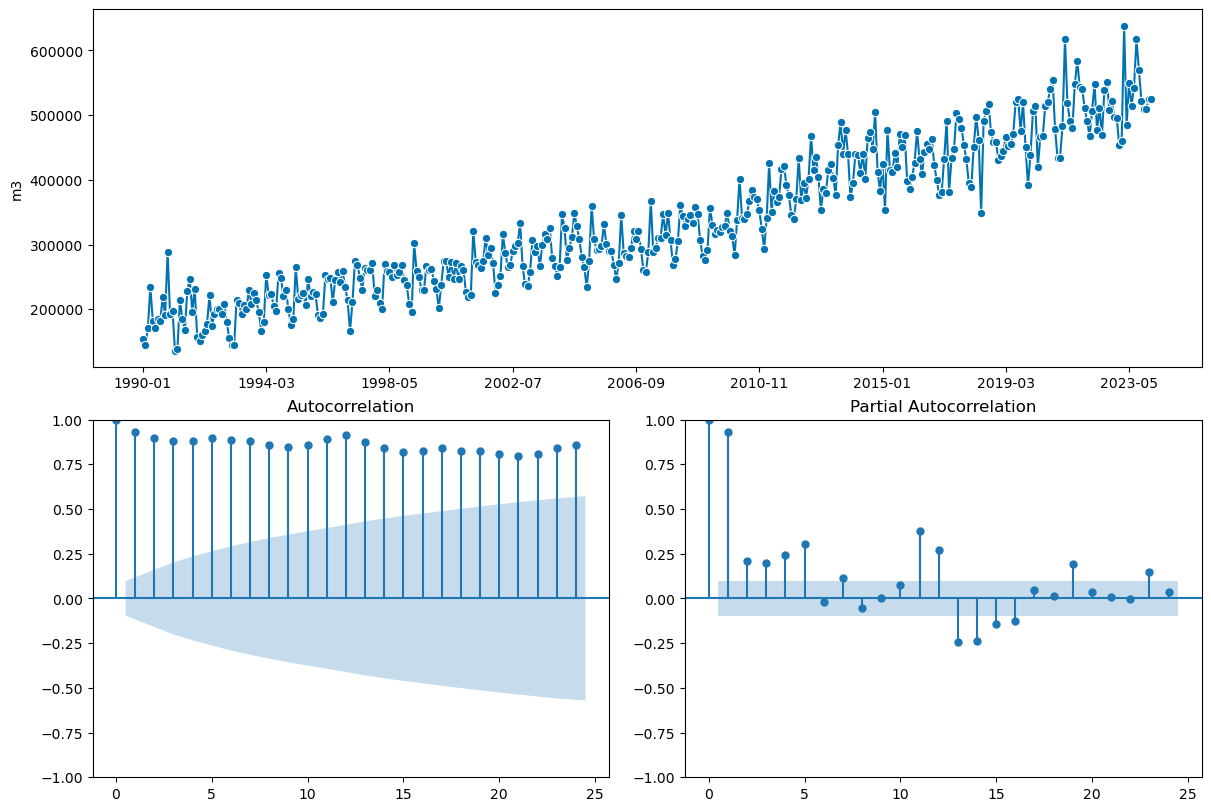

In [17]:
from aeon.visualisation import plot_correlations
fig, ax = plot_correlations(series) 

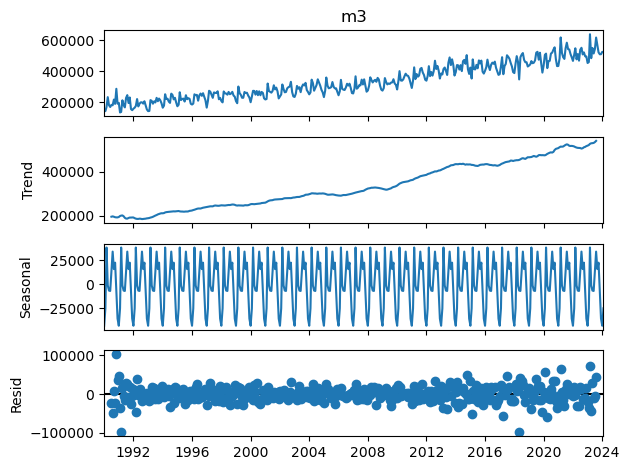

In [18]:
decomposition = plot_decompose(series, True)

In [19]:
series_trend = decomposition.trend
series_seasonal = decomposition.seasonal
series_resid = decomposition.resid
series_trend

1990-01-01   NaN
1990-02-01   NaN
1990-03-01   NaN
1990-04-01   NaN
1990-05-01   NaN
              ..
2023-10-01   NaN
2023-11-01   NaN
2023-12-01   NaN
2024-01-01   NaN
2024-02-01   NaN
Freq: MS, Name: trend, Length: 410, dtype: float64

Podemos observar que a serie nao é estacionaria pois ela possui tendencia. Porém para predições com arima nos teremos que fazer com que as series sejam estacionarias para realizar o forecasting. E para isso podemos remover a tendencia e a sazonalidade.

Note: Tendencia e sazonalidade são os fatores que queremos prever no futuro, entao nao será apenas removido e jogado fora. Ele será apenas separado em partes. Separando esses componentes conseguimos realizar as previsoes neles.


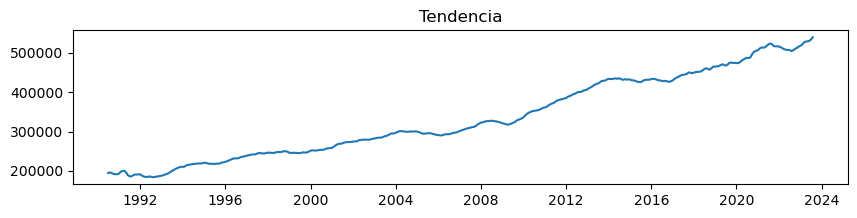

In [20]:
plt.figure(figsize=(10,2))
plt.title('Tendencia')
plt.plot(series_trend)

* ADFULLER TEST (calculo estatistico para dizer se a serie é estacionaria ou nao)

Valores:
* * 1 - Critical Value
* * 2 - Probabilidade de hipotese nula
* * 3 - Numero de lags usadas na regressao para determinar t-statistic. ex: há auto correlacoes voltando 17 periodos.
* * 4 - T values

Se o valor de p-value for maior que 0.05 referencia que a serie não é estacionaria. 
E se critical value maior que os t-values, hipotese nula nao pode ser rejeitada. Entao, os dados nao sao estacionarios


Para determinar se uma série temporal é estacionária usando o teste ADF (Augmented Dickey-Fuller), você pode seguir o seguinte raciocínio:

* Valor p (p-value):
    * Se o valor p for menor que o nível de significância (geralmente 0,05), então você pode rejeitar a hipótese nula (de que a série tem uma raiz unitária, ou seja, não é estacionária) e concluir que a série é estacionária.
    * Se o valor p for maior ou igual ao nível de significância, então você não tem evidências suficientes para rejeitar a hipótese nula e, portanto, a série pode não ser estacionária.
* Estatística de Teste vs. Valores Críticos:
    * Se a estatística de teste é menor que os valores críticos para os níveis de significância de 1%, 5% ou 10%, isso é uma indicação adicional de que a série é estacionária.

In [21]:
from statsmodels.tsa.stattools import adfuller
adftest = adfuller(series)
adftest

(0.8279060121327678,
 0.9920735271337912,
 17,
 392,
 {'1%': -3.44714244478345,
  '5%': -2.8689414326247995,
  '10%': -2.5707127699396084},
 9008.489444280152)

Order do ARIMA
* p: referencia a correlacao de quantos periodos passados o valor atual depende

    * É ordem de AR
    * Classico metodo para encontrar p do arima é usar o PACF.

* q: referencia a correlacao dos erros dos valores anteriores.

    * É ordem de MA dizendo que tem os efeitos de erros anteriores.
    * ACF

* q: Integrated:Diff
    * fazer a diferenca entre previous values e atuais para remover a trend e sazonalidade.
    * d é ordem de quantas vezes diferenciamos a serie.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='m3'>)

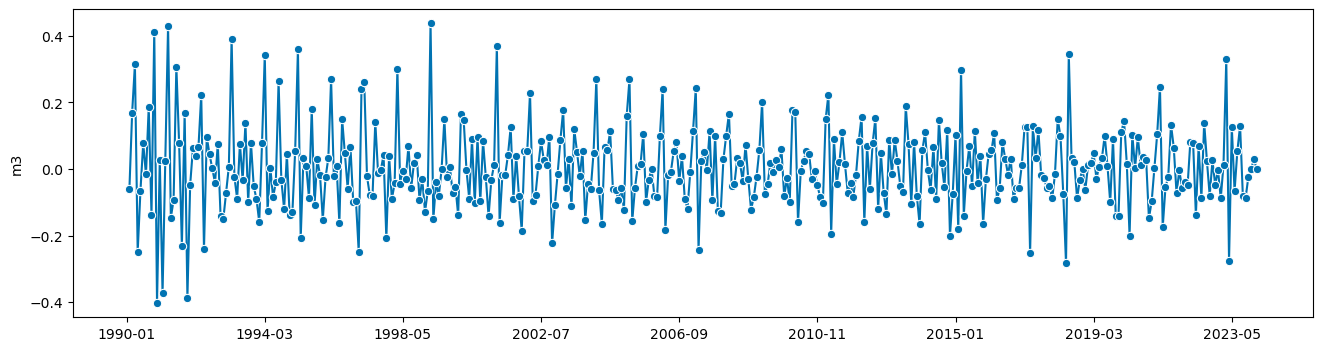

In [22]:
series_diff = np.log(series).diff()
train, test = train_test_stats(series_diff, horizon)
train_data, validation_data = train_test_stats(train, horizon)
plot_series(series_diff)

In [23]:
adftest = adfuller(series_diff.iloc[1:])
adftest

(-4.83114865844741,
 4.739537311670828e-05,
 18,
 390,
 {'1%': -3.4472291365835566,
  '5%': -2.8689795375849223,
  '10%': -2.5707330834976987},
 -941.4210653423361)

In [24]:
def recursive_forecasting_stats(data, model, horizon):
  predictions = []
  pred = pd.Series()
  data_predict = data.copy()
  for _ in range(horizon):    
    next_prediction = model.predict(fh=1)
    data_predict = pd.concat([data_predict, next_prediction.rename('m3')])
    data_predict.index.name = 'timestamp'
    predictions.append(next_prediction.iloc[0])


    pred = pd.concat([pred, next_prediction.rename('m3')])
    model.fit(data_predict)       

  pred.index.name = 'timestamp'
  return pred

In [25]:
forecast = ARIMA(order=(9,0,9), suppress_warnings=True)
forecast.fit(train_data)
preds = recursive_forecasting_stats(train_data, forecast, horizon)

rmse_result = rmse(validation_data, preds)
mape_result = mape(validation_data, preds)
pocid_result = pocid(validation_data, preds)
mcpm_result = mcpm(rmse_result, mape_result, pocid_result)
print(mcpm_result)

_, preds_rescaled = rescaled_split_series([train_data, preds], series, horizon=horizon)
_, test_rescaled = rescaled_split_series([train_data, validation_data], series, horizon=horizon)
plt.figure(figsize=(8,2))
plt.title('Predições na escala original')
plt.plot(test_rescaled.values, label='Actual')
plt.plot(preds_rescaled.values, linewidth=5, alpha=0.4, label='Predicted')
plt.legend()

KeyboardInterrupt: 

739.3609711422146


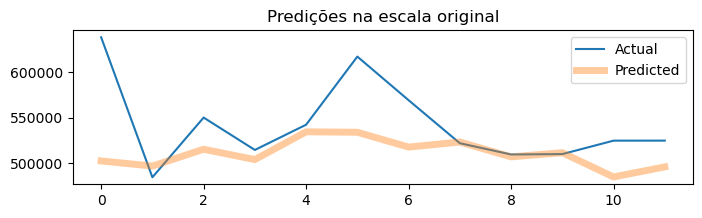

In [ ]:
forecast = ARIMA(order=(9,0,9), suppress_warnings=True)
forecast.fit(train)
preds = recursive_forecasting_stats(train, forecast, horizon)

rmse_result = rmse(test, preds)
mape_result = mape(test, preds)
pocid_result = pocid(test, preds)
mcpm_result = mcpm(rmse_result, mape_result, pocid_result)
print(mcpm_result)
_, preds_rescaled = rescaled_split_series([train, preds], series, horizon=horizon)
_, test_rescaled = rescaled_split_series([train, test], series, horizon=horizon)
plt.figure(figsize=(8,2))
plt.title('Predições na escala original')
plt.plot(test_rescaled.values, label='Actual')
plt.plot(preds_rescaled.values, linewidth=5, alpha=0.4, label='Predicted')
plt.legend()

BUSCAR MELHORES PARAMETROS

In [ ]:
from mango import scheduler, Tuner

def arima_objective_function(args_list):
    global train_values
    global validation_values
    global horizon
    params_evaluated = []

    results = []
    for params in args_list:
        try:
            p,d,q = params['p'],params['d'], params['q']
            
            model = ARIMA(order=(p,d,q), 
                          #seasonal_order=(ps,ds,qs,ss),
                          suppress_warnings=True
                          )
            model.fit(train_values)
            predictions = recursive_forecasting_stats(train_values, model, horizon)
            # mse = mean_squared_error(data_values, predictions.fittedvalues)   
            rmse_result = rmse(validation_values, predictions)
            mape_result = mape(validation_values, predictions)
            pocid_result = pocid(validation_values, predictions)
            mcpm_result = mcpm(rmse_result, mape_result, pocid_result)

            params_evaluated.append(params)
            results.append(mcpm_result)
        except:
            print(f"Exception raised for {params}")
            continue

    return params_evaluated, results

In [ ]:
# param_space_arima = dict(p = range(0, 30),
#                    d = range(0, 30),
#                    q = range(0, 30),
#                   )
# conf_Dict = dict()
# conf_Dict['num_iteration'] = 20
# train_values = train_data
# validation_values = validation_data
# tuner = Tuner(param_space_arima, arima_objective_function, conf_Dict)
# results_arima = tuner.minimize()
# print('best parameters:', results_arima['best_params'])
# print('best loss:', results_arima['best_objective'])
# with open("bests.txt", "a") as arquivo:
#     arquivo.write('----- ARIMA ------\n')
#     arquivo.write(f"best parameters:{results_arima['best_params']}\n")
#     arquivo.write(f"best loss: ${results_arima['best_objective']}\n")

In [ ]:
# import itertools
# p = range(0,12)
# d = range(0,2)
# q = range(0,12)

# all_pdq = list(itertools.product(p,d,q))
# results = []
# for pdq in all_pdq:
#     try:
#         model_arima = ARIMA(order=pdq, suppress_warnings=True)
#         model_arima.fit(train_data)
#         predictions = recursive_forecasting_stats(train_data, model_arima, horizon)
#         # mse = mean_squared_error(data_values, predictions.fittedvalues)   
#         rmse_result = rmse(validation_data, predictions)
#         mape_result = mape(validation_data, predictions)
#         pocid_result = pocid(list(validation_data), predictions)
#         mcpm_result = mcpm(rmse_result, mape_result, pocid_result)
#         results.append((str(pdq),mcpm_result))
#     except Exception as ex:
#         print(ex)
#         print('teve exception')
#         break

# print(results)